[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/19EOxyUNu9IfcVlC-SpYkuzeQpYbmgsSA?usp=sharing)

In [61]:
!pip install fbprophet
!pip install alpha_vantage
!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44.4 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.19.0-py3-none-any.whl (49 kB)
  Using cached webargs-8.2.0-py3-none-any.whl (30 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
 

In [62]:
from alpha_vantage.timeseries import TimeSeries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

1. Suscríbase a las API de Yahoo-Finance y Alpha-Vantage.

In [63]:
#api_key = 'KEKIG9KPOSLX8KG3'
#ts = TimeSeries(key=api_key, output_format='pandas')
#datos, meta_data = ts.get_daily(symbol='AAPL', outputsize='compact')
#print(datos)

In [64]:
msft = yf.Ticker("AAPL")
datos = msft.history()

2. Baje un conjunto  de datos que incluya la mayor cantidad de datos para un conjunto de empresas seleccioandas por usted.

In [65]:
symbols = ['TSLA']
datos = {}
for symbol in symbols:
    datos[symbol] = yf.download(symbol)
df = pd.concat(datos, axis=1)
df = df.loc[:, (slice(None), ['Open', 'Close', 'High', 'Low'])]
df.columns = ['_'.join(col).strip() for col in df.columns.values]

[*********************100%***********************]  1 of 1 completed


In [66]:
df.head()

,TSLA_Open,TSLA_Close,TSLA_High,TSLA_Low
Date,,,,
2010-06-29,1.266667,1.592667,1.666667,1.169333
2010-06-30,1.719333,1.588667,2.028000,1.553333
2010-07-01,1.666667,1.464000,1.728000,1.351333
2010-07-02,1.533333,1.280000,1.540000,1.247333
2010-07-06,1.333333,1.074000,1.333333,1.055333


3. Incluya todas las variables que considere necesario: precio apertura, promedio, alto, bajo , cierre, volumen transado.

In [67]:
TESLA = yf.Ticker("TSLA")
datos = TESLA.history(period="max")
df = pd.DataFrame({'Open': datos['Open'],
                     'High': datos['High'],
                     'Low': datos['Low'],
                     'Close': datos['Close'],
                     'Volume': datos['Volume']})

4. Construya un modelo predictivo con un horizonte de tamaño n, que usted define de acuerdo con la longitud del periodo de cada observación. Mínimo 5 observaciones adelante.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [69]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [70]:
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(test_data['Close'].values, y_pred)
    return mse, y_pred

In [71]:
X_train = train_data[['Open', 'High', 'Low', 'Volume']]
y_train = train_data['Close'].values
X_test = test_data[['Open', 'High', 'Low', 'Volume']]

In [72]:
# Linear Regression
lin_reg = LinearRegression()
mse_lin_reg, y_pred_lin_reg = train_and_predict(lin_reg, X_train, y_train, X_test)


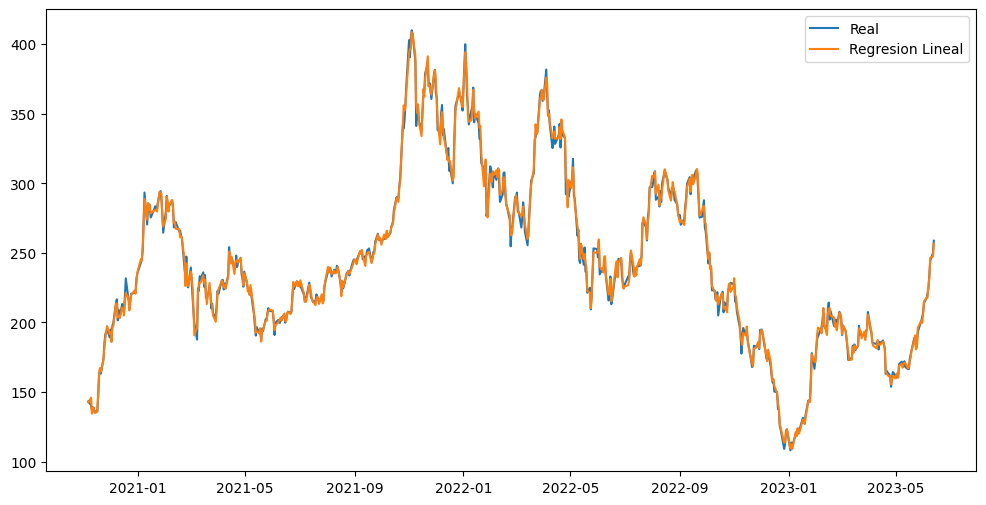

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], test_data['Close'].values, label='Real')
plt.plot(df.index[train_size:], y_pred_lin_reg, label='Regresion Lineal')
plt.legend()
plt.show()

In [74]:
lin_reg.fit(X_train, y_train)
last_30_days = df.tail(30)[['Open', 'High', 'Low', 'Volume']]
predictions = lin_reg.predict(last_30_days)
actuals = df.tail(30)['Close'].values

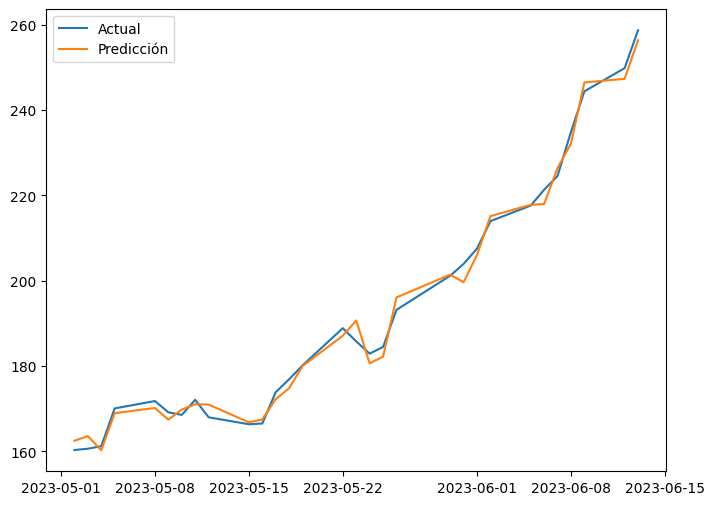

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(df.index[-30:], actuals, label='Actual')
plt.plot(df.index[-30:], predictions, label='Predicción')
plt.legend()
plt.show()

5. Calcule franja de confianza o credibilidad. Para ellos investigue regresión cuantil, boostrap u otro método.

In [76]:
def fit_linear_regression(X, y):
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    return reg.coef_, r2

In [77]:
def generate_bootstrap_samples(data, num_samples):
    samples = []
    for i in range(num_samples):
        sample = data.sample(frac=1, replace=True)
        samples.append(sample)
    return samples

In [78]:
num_samples = 1000
coefficients = []
r2_scores = []
for sample in generate_bootstrap_samples(train_data, num_samples):
    X = sample[['Open', 'High', 'Low', 'Volume']]
    y = sample['Close']
    coef, r2 = fit_linear_regression(X, y)
    coefficients.append(coef)
    r2_scores.append(r2)

In [91]:
lower_bounds = np.percentile(coefficients, 2.5, axis=0)
upper_bounds = np.percentile(coefficients, 97.5, axis=0)

In [92]:
reg = LinearRegression().fit(train_data[['Open', 'High', 'Low', 'Volume']], train_data['Close'])
y_pred = reg.predict(test_data[['Open', 'High', 'Low', 'Volume']])

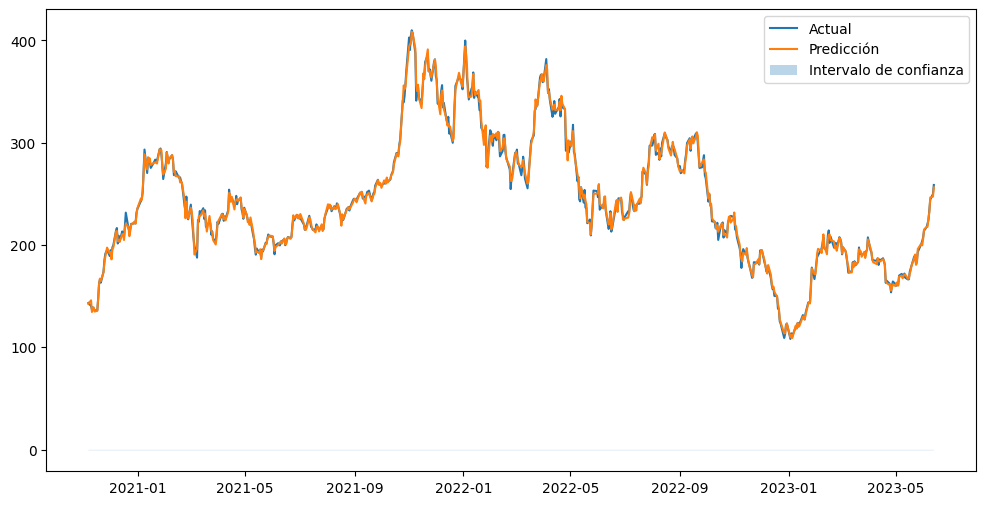

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], test_data['Close'].values, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicción')
plt.fill_between(df.index[train_size:], lower_bounds[0], upper_bounds[0], alpha=0.3, label='Intervalo de confianza')
plt.legend()
plt.show()

In [82]:
y_true = test_data['Close'].tail(30).values
y_pred = y_pred[-30:]

In [83]:
X_pred = test_data[['Open', 'High', 'Low', 'Volume']].tail(30)
pred_coefficients = reg.predict(X_pred)
pred_samples = []
for i in range(num_samples):
    sample = np.dot(X_pred, coefficients[i]) + r2_scores[i] * np.random.normal(size=X_pred.shape[0])
    pred_samples.append(sample)
pred_samples = np.array(pred_samples)
lower_bounds = np.percentile(pred_samples, 2.5, axis=0)
upper_bounds = np.percentile(pred_samples, 97.5, axis=0)

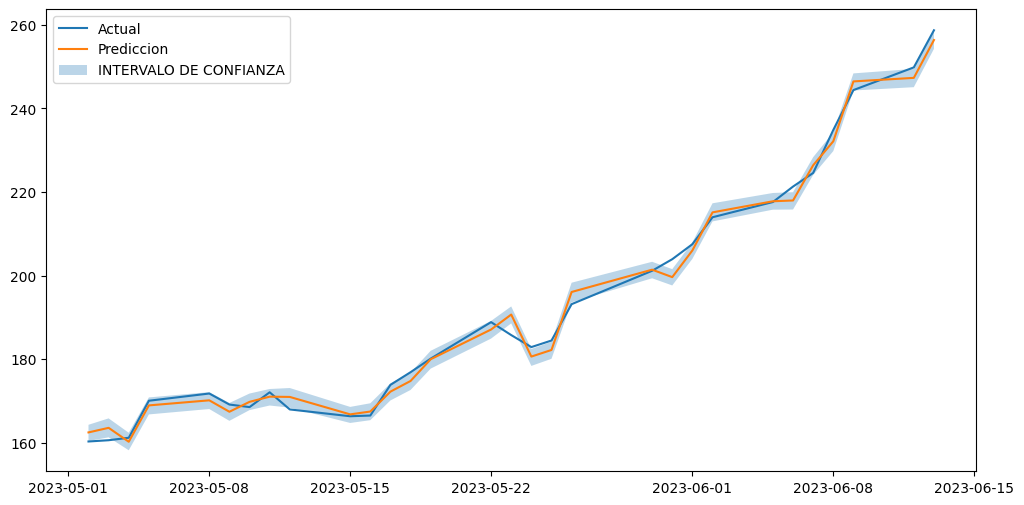

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.tail(30).index, y_true, label='Actual')
plt.plot(test_data.tail(30).index, y_pred, label='Prediccion')
plt.fill_between(test_data.tail(30).index, lower_bounds, upper_bounds, alpha=0.3, label='INTERVALO DE CONFIANZA')
plt.legend()
plt.show()